# Load Images and Masks

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
image_dir = "../Dataset/Image"
mask_dir = "../Dataset/Mask"

In [3]:
def load_image_and_mask(image_path, mask_path, target_size=(256, 256)):
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')
    
    image = load_img(image_path, color_mode='rgb', target_size=target_size)
    mask = load_img(mask_path, color_mode='grayscale', target_size=target_size)
    
    image = img_to_array(image)
    image = image / 255.0
    mask = img_to_array(mask)
    mask = mask / 255.0
    return image, mask

In [4]:
def get_file_paths(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    return image_paths, mask_paths

In [5]:
def create_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def load_data(image_path, mask_path):
        image, mask = tf.py_function(load_image_and_mask, 
                                    [image_path, mask_path], 
                                    [tf.float32, tf.float32])
        image.set_shape([None, None, 3])
        mask.set_shape([None, None, 1])

        return image, mask

    dataset = dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
image_paths, mask_paths = get_file_paths(image_dir, mask_dir)

In [7]:
tuple(zip(image_paths, mask_paths))

(('../Dataset/Image\\0.jpg', '../Dataset/Mask\\0.png'),
 ('../Dataset/Image\\1.jpg', '../Dataset/Mask\\1.png'),
 ('../Dataset/Image\\10.jpg', '../Dataset/Mask\\10.png'),
 ('../Dataset/Image\\1000.jpg', '../Dataset/Mask\\1000.png'),
 ('../Dataset/Image\\1001.jpg', '../Dataset/Mask\\1001.png'),
 ('../Dataset/Image\\1002.jpg', '../Dataset/Mask\\1002.png'),
 ('../Dataset/Image\\1003.jpg', '../Dataset/Mask\\1003.png'),
 ('../Dataset/Image\\1004.jpg', '../Dataset/Mask\\1004.png'),
 ('../Dataset/Image\\1005.jpg', '../Dataset/Mask\\1005.png'),
 ('../Dataset/Image\\1006.jpg', '../Dataset/Mask\\1006.png'),
 ('../Dataset/Image\\1007.jpg', '../Dataset/Mask\\1007.png'),
 ('../Dataset/Image\\1008.jpg', '../Dataset/Mask\\1008.png'),
 ('../Dataset/Image\\1009.jpg', '../Dataset/Mask\\1009.png'),
 ('../Dataset/Image\\1010.jpg', '../Dataset/Mask\\1010.png'),
 ('../Dataset/Image\\1011.jpg', '../Dataset/Mask\\1011.png'),
 ('../Dataset/Image\\1012.jpg', '../Dataset/Mask\\1012.png'),
 ('../Dataset/Image\\101

In [8]:
batch_size=8

In [9]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, 
    mask_paths, 
    test_size=0.2, 
    random_state=42
)

In [10]:
train_set = create_dataset(train_image_paths, train_mask_paths, batch_size=batch_size)
test_set = create_dataset(test_image_paths, test_mask_paths, batch_size=batch_size)

# Plot the dataset

In [11]:
import gc

gc.collect()

0

In [12]:
for images, masks in train_set.take(1):
    first_image = images[0].numpy()
    first_mask = masks[0].numpy()
    break

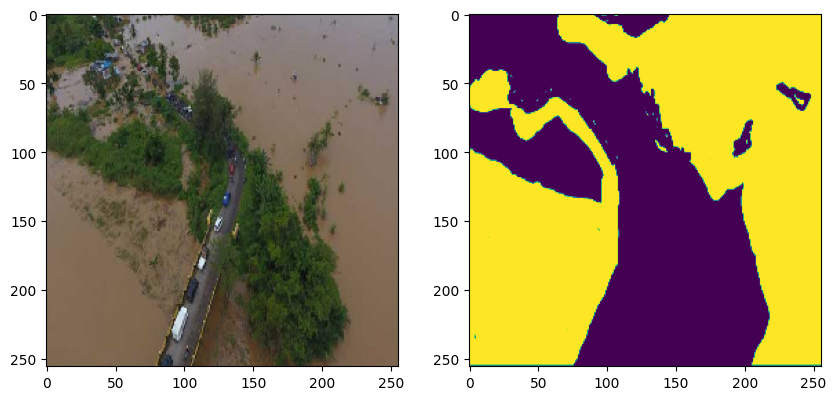

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(first_image)
plt.subplot(1, 2, 2)
plt.imshow(first_mask)

# Define model

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [15]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # bottle neck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4], axis=3)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3], axis=3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2], axis=3)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [16]:
model = unet()

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [18]:
tf.keras.utils.plot_model(model, to_file='../Model/lighter_model.pdf', show_shapes=True, show_layer_names=True)

In [19]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy']
             )

In [20]:
gc.collect()

124

In [21]:
epochs = 50

In [22]:
history = model.fit(
    train_set, 
    validation_data=test_set,
    epochs=epochs,
    shuffle=True
)

Epoch 1/50
29/29 [==============================] - 11s 178ms/step - loss: 0.6898 - accuracy: 0.6237 - val_loss: 0.6839 - val_accuracy: 0.7844
Epoch 2/50
29/29 [==============================] - 4s 152ms/step - loss: 0.6312 - accuracy: 0.7143 - val_loss: 0.5484 - val_accuracy: 0.7460
Epoch 3/50
29/29 [==============================] - 5s 155ms/step - loss: 0.5954 - accuracy: 0.6889 - val_loss: 0.5376 - val_accuracy: 0.7637
Epoch 4/50
29/29 [==============================] - 4s 153ms/step - loss: 0.5251 - accuracy: 0.7675 - val_loss: 0.4900 - val_accuracy: 0.7878
Epoch 5/50
29/29 [==============================] - 5s 158ms/step - loss: 0.4904 - accuracy: 0.7862 - val_loss: 0.4485 - val_accuracy: 0.8011
Epoch 6/50
29/29 [==============================] - 5s 160ms/step - loss: 0.4740 - accuracy: 0.7892 - val_loss: 0.4427 - val_accuracy: 0.8053
Epoch 7/50
29/29 [==============================] - 4s 154ms/step - loss: 0.4451 - accuracy: 0.8021 - val_loss: 0.4219 - val_accuracy: 0.8191
Epoch

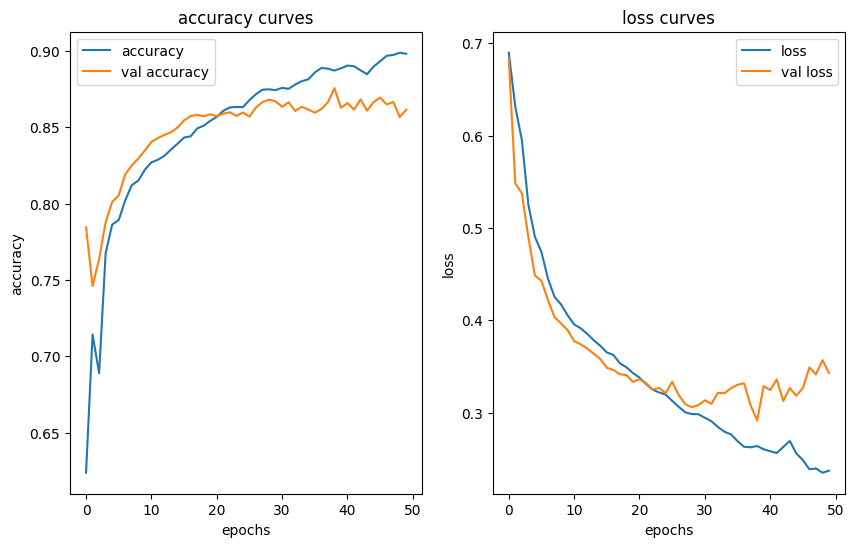

In [23]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot([i for i in range(epochs)], history.history['accuracy'], label='accuracy')
plt.plot([i for i in range(epochs)], history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy curves')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([i for i in range(epochs)], history.history['loss'], label='loss')
plt.plot([i for i in range(epochs)], history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss curves')
plt.legend() 

# Save the model

In [24]:
model.save("../Model/seg_model.h5")

# Load the model

In [25]:
from keras.models import load_model


loaded_model = load_model("../Model/seg_model_best_weights.h5")

# Visualize the model's work

In [26]:
for images, masks in test_set.take(3):
    test_img = images[0].numpy()
    test_mask = masks[0].numpy()

In [27]:
pred_mask = loaded_model.predict(tf.expand_dims(test_img, axis=0))
pred_mask.shape

1/1 [==============================] - 1s 751ms/step


(1, 256, 256, 1)

Text(0.5, 1.0, 'real mask')

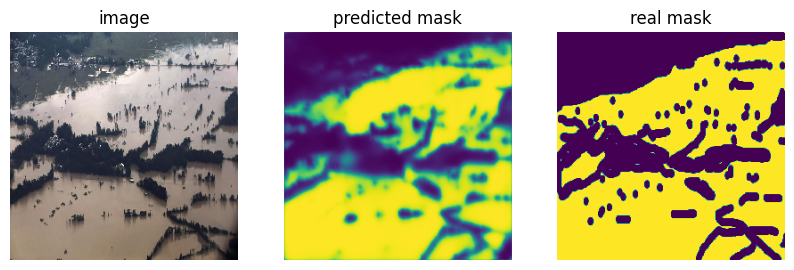

In [28]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_img)
plt.axis('off')
plt.title('image')
plt.subplot(1, 3, 2)
plt.imshow(pred_mask[0])
plt.axis('off')
plt.title('predicted mask')
plt.subplot(1, 3, 3)
plt.imshow(test_mask)
plt.axis('off')
plt.title('real mask')

# Test with image not in the dataset

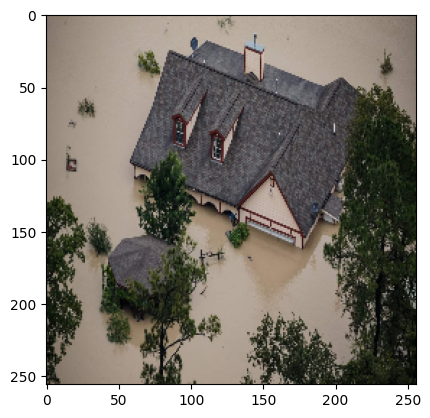

In [29]:
import cv2


real_img = plt.imread('../Test Images/test1.jpg')
real_img = cv2.resize(real_img, (256, 256))
real_img = real_img/255.0
plt.imshow(real_img)

In [30]:
real_img_mask = loaded_model.predict(tf.expand_dims(real_img, axis=0))[0]

1/1 [==============================] - 0s 143ms/step


In [31]:
real_img.shape, real_img_mask.shape, type(real_img), type(real_img_mask), real_img.size, real_img_mask.size

((256, 256, 3), (256, 256, 1), numpy.ndarray, numpy.ndarray, 196608, 65536)

In [32]:
import pandas as pd


df = pd.DataFrame(real_img_mask[:, :, 0])
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,...,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,0.448092,0.470975,0.486289,0.498909,0.510330,0.518982,0.530717,0.546998,0.566282,0.577748,...,0.247857,0.249667,0.251217,0.253450,0.255643,0.257135,0.261331,0.259133,0.255128,0.244196
std,0.390449,0.443842,0.459649,0.463266,0.464743,0.463935,0.461746,0.458959,0.457562,0.457446,...,0.413250,0.413698,0.412990,0.413620,0.413452,0.413712,0.414584,0.410043,0.398303,0.345488
min,0.012416,0.001739,0.000889,0.001000,0.001211,0.001573,0.001925,0.002188,0.002305,0.002365,...,0.000314,0.000289,0.000302,0.000297,0.000342,0.000272,0.000465,0.000553,0.001421,0.013505
25%,0.028571,0.006145,0.003840,0.004725,0.005640,0.006411,0.006894,0.007890,0.009503,0.011748,...,0.000688,0.000685,0.000732,0.000735,0.000837,0.000762,0.001435,0.001578,0.003188,0.021893
50%,0.436975,0.390636,0.384171,0.388388,0.393702,0.414221,0.578584,0.755038,0.876565,0.923271,...,0.001427,0.001303,0.001230,0.001088,0.001219,0.001130,0.002142,0.002445,0.004616,0.025499
75%,0.848668,0.928926,0.959410,0.974463,0.984858,0.989603,0.992663,0.994045,0.995308,0.995910,...,0.616832,0.637705,0.680796,0.739553,0.755882,0.759520,0.800830,0.767604,0.734103,0.605616
max,0.871452,0.947194,0.973343,0.983871,0.990913,0.994038,0.995832,0.996420,0.996951,0.997180,...,0.993824,0.992809,0.990682,0.988723,0.986526,0.985101,0.984960,0.980677,0.963147,0.884270


Text(0.5, 1.0, 'show only flooded areas')

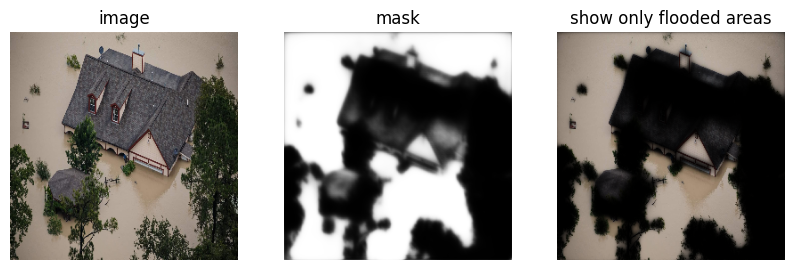

In [33]:
plt.figure(figsize=(10, 6))

axis = 'off'

plt.subplot(1, 3, 1)
plt.imshow(real_img)
plt.axis(axis)
plt.title('image')

plt.subplot(1, 3, 2)
plt.imshow(real_img_mask, cmap='gray')
plt.axis(axis)
plt.title('mask')

plt.subplot(1, 3, 3)
result = real_img * real_img_mask[:, :, :]
real_img_mask = (real_img_mask < 0.5).astype(float)
plt.imshow(result)
plt.axis(axis)
plt.title('show only flooded areas')